## DNSC 6279 Spring 2019 Assignment 3
## Group 6 -- Yixuan Huang, Ada Li, Xinyu Wang, Jingsi Wu
#### In this assignment we will use the data created in assignment 2 to build gradient boosting and multilayer perceptron classifiers to predict whether a shopper will become a repeat shopper. 

In [1]:
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.grid.grid_search import H2OGridSearch
%matplotlib inline

In [2]:
# read data 
train_pd = pd.read_csv('C:/Users/Administrator/Downloads/DM_hyx/assign_05_train.csv')
valid_pd = pd.read_csv('C:/Users/Administrator/Downloads/DM_hyx/assign_05_valid.csv')
test_pd = pd.read_csv('C:/Users/Administrator/Downloads/DM_hyx/assign_05_test.csv')

In [3]:
# change related columns' name 
train_pd.rename(columns={'exact_item_bought':'purchased'},inplace = True)
valid_pd.rename(columns={'exact_item_bought':'purchased'},inplace = True)
test_pd.rename(columns={'exact_item_bought':'purchased'},inplace = True)

In [4]:
# start and import h2o
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\Users\Administrator\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmpfeu20klb
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmpfeu20klb\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmpfeu20klb\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_Administrator_amnv1k
H2O cluster total nodes:,1
H2O cluster free memory:,5.314 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [5]:
# enforce same measurement levels in h2o and pandas
col_types = {'chain': 'enum',
             'offer': 'enum',
             'market': 'enum',
             'category': 'enum',
             'company': 'enum',
             'brand': 'enum',
             'purchased': 'enum',
             'month': 'enum',
             'week': 'enum'}

train = h2o.H2OFrame(train_pd, column_types=col_types)
valid = h2o.H2OFrame(valid_pd, column_types=col_types)
test = h2o.H2OFrame(test_pd, column_types=col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
train.describe()

Rows:64122
Cols:18




,id,chain,offer,market,repeater,offerdate,category,quantity,company,offervalue,brand,avg_category_quantity,avg_category_amount,purchased,month,week,dayOfWeek,day
type,int,enum,enum,enum,int,int,enum,int,enum,real,enum,real,real,enum,enum,enum,enum,int
mins,86246.0,,,,0.0,1362096000000.0,,1.0,,0.75,,-1.0,-85.14,,,,,1.0
mean,1865046990.705777,,,,0.2693771248557437,1365226057677.5579,,1.0,,1.255356975764942,,0.6942286652420018,2.2440281205381436,,,,,19.029849349677097
maxs,4809911000.0,,,,1.0,1367280000000.0,,1.0,,3.0,,44.181818182,60.802,,,,,31.0
sigma,1567329467.9984725,,,,0.4436396723261261,1304850779.386149,,0.0,,0.5238038613432835,,0.7714497289290286,2.6319680001789507,,,,,9.628506814875884
zeros,0,,,,46849,0,,0,,0,,29124,29138,,,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,86246.0,205,1208251,34,1.0,1366761600000.0,2202,1.0,104460040,2.0,3718,0.0,0.0,0,4,17,Wed,24.0
1,12682470.0,18,unknown,11,0.0,1364428800000.0,unknown,1.0,unknown,0.75,unknown,1.0,2.5,1,3,13,Thu,28.0
2,13807224.0,4,1204576,1,0.0,1365120000000.0,5616,1.0,104610040,1.0,15889,1.4375,3.365,1,4,14,Fri,5.0


In [7]:
# check shape 
print(train.shape)
print(valid.shape)
print(test.shape)

(64122, 18)
(47980, 18)
(47955, 18)


In [8]:
# set modeling roles
y = 'repeater'
X = ['category', 'company', 'brand', 'offer', 'offervalue', 'avg_category_quantity', 'avg_category_amount', 'purchased', 'month', 'week', 'dayOfWeek', 'day']
print(y)
print(X)

repeater
['category', 'company', 'brand', 'offer', 'offervalue', 'avg_category_quantity', 'avg_category_amount', 'purchased', 'month', 'week', 'dayOfWeek', 'day']


## Target encoding

In [9]:
from h2o.targetencoder import TargetEncoder

In [10]:
e_columns = ['market', 'chain']
te_ = TargetEncoder(x=e_columns, y=y)
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()
_ = te_.fit(train)
e_train = te_.transform(frame=train, holdout_type='loo', seed=12345)
e_valid = te_.transform(frame=valid, holdout_type='loo', seed = 12345)
e_test = te_.transform(frame=test, holdout_type='loo', seed = 12345)

In [11]:
e_train.describe()

Rows:64122
Cols:20




,chain,market,id,offer,repeater,offerdate,category,quantity,company,offervalue,brand,avg_category_quantity,avg_category_amount,purchased,month,week,dayOfWeek,day,market_te,chain_te
type,enum,enum,int,enum,enum,int,enum,int,enum,real,enum,real,real,enum,enum,enum,enum,int,real,real
mins,,,86246.0,,,1362096000000.0,,1.0,,0.75,,-1.0,-85.14,,,,,1.0,0.10759824712102006,-0.009653338193893433
mean,,,1865046990.70578,,,1365226057677.5527,,1.0,,1.2553569757649494,,0.6942286652420042,2.2440281205381414,,,,,19.029849349677193,0.2693905869004866,0.26941983906417755
maxs,,,4809911000.0,,,1367280000000.0,,1.0,,3.0,,44.181818182,60.802,,,,,31.0,0.454076468074523,0.7529095890684139
sigma,,,1567329467.9984708,,,1304850779.3854635,,0.0,,0.5238038613432845,,0.7714497289290287,2.6319680001789556,,,,,9.628506814875902,0.057095947892206955,0.08691822834932567
zeros,,,0,,,0,,0,,0,,29124,29138,,,,,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,10,5,255092083.0,unknown,0,1363219200000.0,unknown,1.0,unknown,2.0,unknown,1.0,9.99,1,3,11,Thu,14.0,0.1627033019370961,0.16072797465165198
1,10,5,266075492.0,1204576,1,1365033600000.0,5616,1.0,104610040,1.0,15889,1.0,2.79,1,4,14,Thu,4.0,0.12530765537614094,0.12405231725196142
2,10,5,266258515.0,unknown,0,1363737600000.0,unknown,1.0,unknown,2.0,unknown,1.25,3.25,1,3,12,Wed,20.0,0.15795085075568435,0.1603235213740641


## GBM

In [12]:
# set modeling roles in GBM
predictor=X+['market_te','chain_te']
print(predictor)

['category', 'company', 'brand', 'offer', 'offervalue', 'avg_category_quantity', 'avg_category_amount', 'purchased', 'month', 'week', 'dayOfWeek', 'day', 'market_te', 'chain_te']


In [30]:
# GBM with random hyperparameter search
# train many different GBM models with random hyperparameters
# and select best model based on validation error

#Define parameters for grid search
hyper_parameters = {'ntrees':list(range(0, 800, 50)),
                    'max_depth':list(range(1, 20, 2)),                    
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':1000}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=predictor,
              y=y,
              training_frame=e_train,
              validation_frame=e_valid,
               seed=12345)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [31]:
# show grid search results
gsearch.show()
# select best model
gbm_model = gsearch.get_grid()[0]
# print model information
gbm_model

     col_sample_rate max_depth ntrees sample_rate  \
0                0.9         5    750         0.7   
1                0.5         3    550         0.7   
2                1.0         3    400         0.4   
3                0.2         7    400         0.9   
4                0.2         7    300         0.9   
5                0.9         3    750         0.3   
6                0.8         3    600         0.3   
7                1.0         3    750         0.3   
8                0.2         9    650         1.0   
9                0.4         9    300         0.8   
10               0.5         9    300         0.8   
11               0.1        19    400         0.4   
12               0.1        17    300         0.4   
13               0.6         7    200         0.4   
14               0.3         9     50         0.3   
15               0.9         9    100         0.6   
16               0.3        11    500         0.9   
17               0.1        15    200         

,0,1,Error,Rate
0,31802.0,15047.0,0.3212,(15047.0/46849.0)
1,5794.0,11479.0,0.3354,(5794.0/17273.0)
Total,37596.0,26526.0,0.325,(20841.0/64122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2899238,0.5241672,220.0
max f2,0.1617382,0.6814137,313.0
max f0point5,0.3749493,0.4977210,163.0
max accuracy,0.4931607,0.7549515,95.0
max precision,0.9281076,1.0,0.0
max recall,0.0257389,1.0,398.0
max specificity,0.9281076,1.0,0.0
max absolute_mcc,0.3118332,0.3122507,206.0
max min_per_class_accuracy,0.2851527,0.6701317,223.0
max mean_per_class_accuracy,0.2927551,0.6717402,218.0


Gains/Lift Table: Avg response rate: 26.94 %, avg score: 26.94 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100122,0.6479071,3.2670269,3.2670269,0.8800623,0.7018711,0.8800623,0.7018711,0.0327100,0.0327100,226.7026871,226.7026871
,2,0.0200087,0.5995224,2.6292816,2.9484028,0.7082683,0.6215500,0.7942323,0.6617419,0.0262838,0.0589938,162.9281648,194.8402796
,3,0.0300053,0.5714341,2.5250370,2.8073542,0.6801872,0.5846670,0.7562370,0.6360636,0.0252417,0.0842355,152.5037001,180.7354213
,4,0.0400019,0.5523472,2.3802528,2.7006205,0.6411856,0.5614325,0.7274854,0.6174131,0.0237944,0.1080299,138.0252769,170.0620480
,5,0.0500140,0.5362277,2.2551159,2.6114362,0.6074766,0.5439233,0.7034612,0.6027014,0.0225786,0.1306085,125.5115893,161.1436213
,6,0.1000125,0.4767574,1.9765568,2.2940460,0.5324392,0.5040758,0.6179635,0.5533963,0.0988248,0.2294332,97.6556758,129.4045985
,7,0.1500109,0.4341890,1.7843433,2.1241627,0.4806613,0.4552339,0.5722009,0.5206789,0.0892144,0.3186476,78.4343271,112.4162743
,8,0.2000094,0.3914450,1.5076022,1.9700346,0.4061135,0.4120141,0.5306823,0.4935148,0.0753778,0.3940254,50.7602167,97.0034618
,9,0.3000062,0.3415944,1.3918109,1.7773034,0.3749220,0.3636450,0.4787649,0.4502271,0.1391767,0.5332021,39.1810910,77.7303401
,10,0.4000031,0.2965605,1.1677548,1.6249222,0.3145664,0.3195616,0.4377169,0.4175620,0.1167718,0.6499739,16.7754827,62.4922199




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.17820593644634106
RMSE: 0.42214444974006354
LogLoss: 0.5343483746616521
Mean Per-Class Error: 0.3563338931412545
AUC: 0.6969932580054605
pr_auc: 0.452492011863019
Gini: 0.39398651601092105
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23649055835720253: 


,0,1,Error,Rate
0,19925.0,15068.0,0.4306,(15068.0/34993.0)
1,3703.0,9284.0,0.2851,(3703.0/12987.0)
Total,23628.0,24352.0,0.3912,(18771.0/47980.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2364906,0.4972817,251.0
max f2,0.1211758,0.6678104,343.0
max f0point5,0.3896769,0.4611970,147.0
max accuracy,0.4859506,0.7391830,92.0
max precision,0.8528715,1.0,0.0
max recall,0.0257059,1.0,398.0
max specificity,0.8528715,1.0,0.0
max absolute_mcc,0.2542966,0.2555923,240.0
max min_per_class_accuracy,0.2786502,0.6414876,224.0
max mean_per_class_accuracy,0.2542966,0.6436661,240.0


Gains/Lift Table: Avg response rate: 27.07 %, avg score: 26.98 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100042,0.6382292,2.4398854,2.4398854,0.6604167,0.6866284,0.6604167,0.6866284,0.0244090,0.0244090,143.9885398,143.9885398
,2,0.0200083,0.5938314,2.3244334,2.3821594,0.6291667,0.6135333,0.6447917,0.6500809,0.0232540,0.0476630,132.4433408,138.2159403
,3,0.0300125,0.5669256,2.0396518,2.2679902,0.5520833,0.5792593,0.6138889,0.6264737,0.0204050,0.0680681,103.9651831,126.7990212
,4,0.0400167,0.5498976,2.0550454,2.2147540,0.55625,0.5581320,0.5994792,0.6093883,0.0205590,0.0886271,105.5045430,121.4754017
,5,0.05,0.5354243,1.9976328,2.1714022,0.5407098,0.5423927,0.5877449,0.5960115,0.0199430,0.1085701,99.7632770,117.1402171
,6,0.1,0.4750214,1.8880419,2.0297220,0.5110463,0.5026131,0.5493956,0.5493123,0.0944021,0.2029722,88.8041888,102.9722030
,7,0.15,0.4335942,1.7109417,1.9234619,0.4631096,0.4537008,0.5206336,0.5174418,0.0855471,0.2885193,71.0941711,92.3461923
,8,0.2,0.3927370,1.5169015,1.8218218,0.4105877,0.4119360,0.4931221,0.4910654,0.0758451,0.3643644,51.6901517,82.1821822
,9,0.3000208,0.3412058,1.2417524,1.6284385,0.3361117,0.3636066,0.4407780,0.4485732,0.1242011,0.4885655,24.1752436,62.8438495
,10,0.4,0.2968000,1.1644839,1.5124740,0.3151970,0.3193719,0.4093893,0.4162796,0.1164241,0.6049896,16.4483866,51.2474012



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-07 21:54:15,2 min 36.117 sec,0.0,0.4436362,0.5826383,0.5,0.0,1.0,0.7306229,0.4443105,0.5839336,0.5,0.0,1.0,0.7293247
,2019-04-07 21:54:15,2 min 36.150 sec,1.0,0.4398076,0.5740972,0.6870773,0.4233282,1.9554024,0.3570070,0.4407186,0.5759099,0.6760086,0.4126611,1.8366015,0.3661526
,2019-04-07 21:54:15,2 min 36.182 sec,2.0,0.4366686,0.5672062,0.6897759,0.4355869,2.1001674,0.3766570,0.4378016,0.5695025,0.6783600,0.4242254,2.0044431,0.3877241
,2019-04-07 21:54:15,2 min 36.216 sec,3.0,0.4340947,0.5616013,0.6915946,0.4394542,2.1916760,0.3595490,0.4354532,0.5643842,0.6797788,0.4264486,2.0643368,0.3695081
,2019-04-07 21:54:15,2 min 36.250 sec,4.0,0.4319849,0.5570107,0.6922816,0.4250534,2.3338729,0.3593151,0.4335460,0.5602311,0.6803274,0.4148477,2.1817699,0.3690704
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-04-07 21:54:19,2 min 39.891 sec,51.0,0.4177552,0.5247657,0.7142640,0.4771743,2.8069754,0.3715417,0.4232601,0.5368172,0.6925838,0.4458836,2.3244334,0.3969779
,2019-04-07 21:54:19,2 min 39.985 sec,52.0,0.4176790,0.5246225,0.7144232,0.4779242,2.8126691,0.3705125,0.4232402,0.5367842,0.6925739,0.4460690,2.3398270,0.3942893
,2019-04-07 21:54:19,2 min 40.079 sec,53.0,0.4176351,0.5245294,0.7145867,0.4780973,2.8289443,0.3707152,0.4232156,0.5367361,0.6926187,0.4462083,2.3398270,0.3925386
,2019-04-07 21:54:23,2 min 44.089 sec,496.0,0.4110337,0.5106037,0.7368643,0.5188494,3.2670269,0.3250211,0.4221444,0.5343484,0.6969933,0.4524920,2.4398854,0.3912255



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
chain_te,2221.3571777,1.0,0.2704848
week,1959.7998047,0.8822533,0.2386361
avg_category_amount,789.7592163,0.3555300,0.0961655
market_te,699.4074097,0.3148559,0.0851637
offer,573.7058716,0.2582682,0.0698576
avg_category_quantity,563.6896362,0.2537591,0.0686380
offervalue,393.4486694,0.1771208,0.0479085
dayOfWeek,348.2767639,0.1567856,0.0424081
category,204.1903992,0.0919215,0.0248634
brand,177.0473938,0.0797024,0.0215583


In [32]:
# measure gbm AUC of train and valid
print(gbm_model.auc(train=True))
print(gbm_model.auc(valid=True))

0.736864275138909
0.6969932580054605


## Answer the following questions:

### 1.(1 pt.) What is the value for chain_te for row id 258692579?  
### Answer：0.131497

In [33]:
# 1.(1 pt.) What is the value for chain_te for row id 258692579?  
e_test[e_test['id']==258692579]['chain_te']

chain_te
0.131497


### 2.(1 pt.) What is the value of market_te for the same row?
### Answer： 0.121452

In [34]:
# 2.(1 pt.) What is the value of market_te for the same row?
e_test[e_test['id']==258692579]['market_te']

market_te
0.121452


### 3.(1 pt.) What is the test AUC of your best GBM model?
### Answer:

In [35]:
# 3.(1 pt.) What is the test AUC of your best GBM model?
print(gbm_model.model_performance(test_data=e_test).auc())

0.7045303135207195


### 4.(3 pts.) What are the three most important variables for your best GBM? Paste a screenshot of your output here.
### Answer: The three most important variables for your best GBM are chain_te, week, avg_categroy_amount

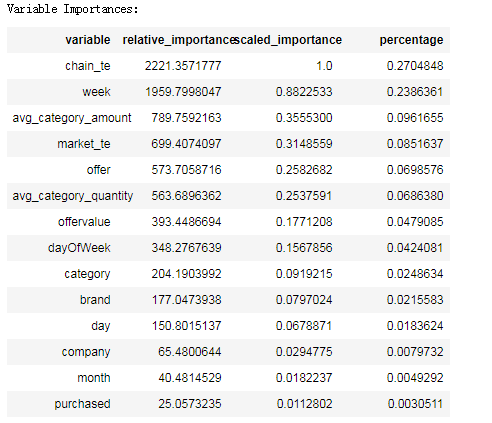

In [36]:
# 4.(3 pts.) What are the three most important variables for your best GBM? 

from PIL import Image
Image.open('C:/Users/Administrator/Downloads/DM_hyx/Assignment03_Group6/variable_importances.png')

### 5.(1 pt.) Paste the partial dependence plot of the most important variable in the GBM model’s test data here.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model Grid_GBM_py_2_sid_80e8_model_python_1554686365246_11004_model_15 on column 'chain_te'



chain_te,mean_response,stddev_response,std_error_mean_response
-0.0094539,0.4273968,0.2057476,0.0009395
0.0308560,0.4273968,0.2057476,0.0009395
0.0711659,0.2189410,0.1341106,0.0006124
0.1114758,0.0720997,0.0414452,0.0001893
0.1517857,0.2060743,0.0863963,0.0003945
0.1920957,0.2437471,0.1083981,0.0004950
0.2324056,0.2843826,0.1237170,0.0005650
0.2727155,0.2898669,0.1369035,0.0006252
0.3130254,0.2843670,0.1292072,0.0005900
0.3533353,0.1799820,0.1086011,0.0004959


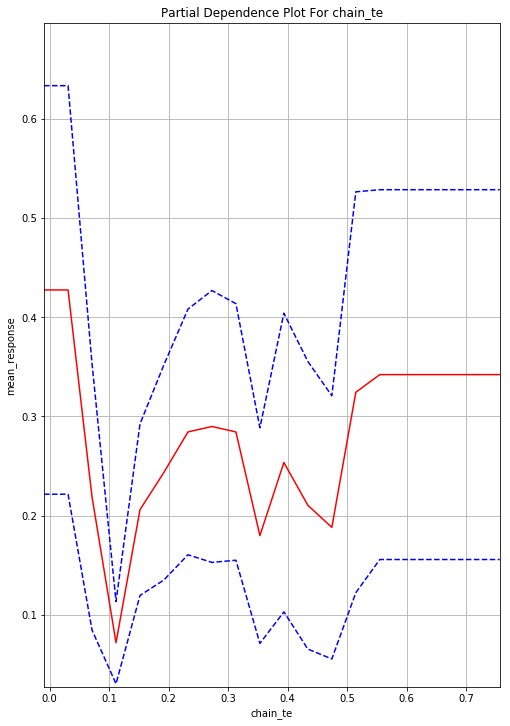

In [37]:
# 5.(1 pt.) Paste the partial dependence plot of the most important variable in the GBM model’s test data here.
import matplotlib as plt
gbm_pdp = gbm_model.partial_plot(data=e_test, cols = ['chain_te'], plot=True, nbins = 20)
gbm_pdp[0]

## MLP

In [38]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
#Select 10 most important input variables from the GBM.
Predictor_MLP = ['chain_te','week','avg_category_amount','market_te','offer','avg_category_quantity','offervalue',
                 'dayOfWeek','category','brand']

# NN with random hyperparameter search
# train many different NN models with random hyperparameters
# and select best model based on validation error
# define random grid search parameters
mlp_params = {'hidden': [[10, 10, 10], [20, 20, 20], [30, 30, 30], [40, 40, 40]],
              'l1': [0, 0.0001, 0.001],
              'l2': [0, 0.0001, 0.001],
              'input_dropout_ratio': [0, 0.1, 0.2]}

# define search strategy
mlp_search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':600}

# initialize grid search
mlp_search = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=mlp_params,
                        search_criteria=mlp_search_criteria)

# execute training w/ grid search
mlp_search.train(x=Predictor_MLP,
              y=y,
              training_frame=e_train,
              validation_frame=e_valid,
              seed=12345)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [39]:
# select best model
mlpsearch_sort = mlp_search.get_grid(sort_by='auc', decreasing=True)
best_mlp = mlpsearch_sort.models[0]

## Answer the following questions:
### 6.(1 pt.) What is the test AUC of your best MLP model? Paste a screenshot of your output here.
### Answer:

In [40]:
# 6.(1 pt.) What is the test AUC of your best MLP model? Paste a screenshot of your output here.
best_mlp_perf = best_mlp.model_performance(e_test)
best_mlp_perf.auc()

0.6938984404386672

### 7.(1 pt.) Paste the partial dependence plot of the same variable in #5,  but for your best ANN model’s test data, here.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model Grid_DeepLearning_py_2_sid_80e8_model_python_1554686365246_15872_model_5 on column 'chain_te'



chain_te,mean_response,stddev_response,std_error_mean_response
-0.0094539,0.0669998,0.0369516,0.0001687
0.0308560,0.0885608,0.0481143,0.0002197
0.0711659,0.1149199,0.0603852,0.0002757
0.1114758,0.1465042,0.0742617,0.0003391
0.1517857,0.1830473,0.0906851,0.0004141
0.1920957,0.2227996,0.1085109,0.0004955
0.2324056,0.2546839,0.1176338,0.0005372
0.2727155,0.2722912,0.1214672,0.0005547
0.3130254,0.2804044,0.1240340,0.0005664
0.3533353,0.2848451,0.1272905,0.0005813


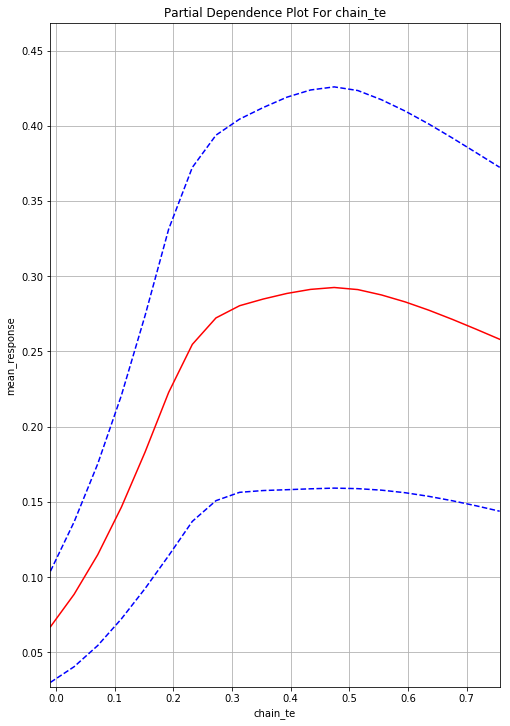

In [41]:
# 7.(1 pt.) Paste the partial dependence plot of the same variable in #5, 
# but for your best ANN model’s test data, here.
mlp_pdp = best_mlp.partial_plot(data=e_test, cols = ['chain_te'], plot=True, nbins = 20)
mlp_pdp[0]

In [42]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_80e8 closed.
